In [1]:
import tensorflow as tf

In [3]:
import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras import layers

In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [5]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url,input_shape = IMAGE_SHAPE+(3,))
])

65536/61306 [================================] - 0s 4us/step


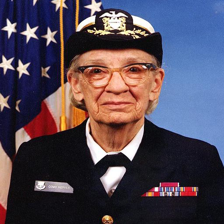

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [9]:
#Add a batch dimension, and pass the image to the model.
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [10]:
predicted_class = np.argmax(result[0],axis = -1)
predicted_class

653

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


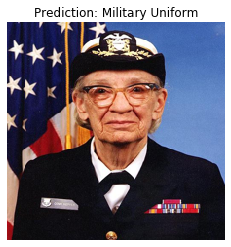

In [12]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [13]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [14]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [15]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [16]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [17]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['cabbage butterfly', 'daisy', 'daisy', 'apiary', 'slug',
       'chickadee', 'grocery store', 'porcupine', 'sea urchin',
       'greenhouse', 'daisy', 'red-backed sandpiper', 'conch',
       'passenger car', 'barn spider', 'spider web', 'bee', 'daisy',
       'broom', 'daisy', 'cardoon', 'daisy', 'honeycomb', 'daisy',
       'bearskin', 'cauliflower', 'hip', 'daisy', 'mantis', 'daisy',
       'daisy', 'tile roof'], dtype='<U30')

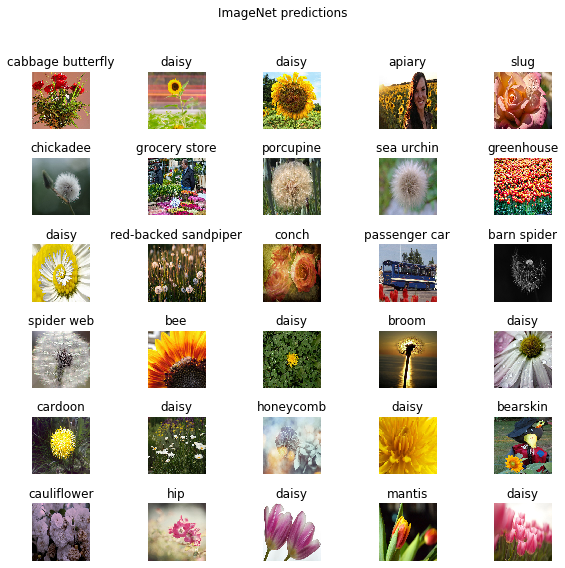

In [18]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [19]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [20]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [21]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [22]:
feature_extractor_layer.trainable = False

In [23]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 5])

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [27]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [28]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
115/115 [==============================] - 153s 1s/step - loss: 0.3923 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 118s 1s/step - loss: 0.3853 - acc: 0.8125


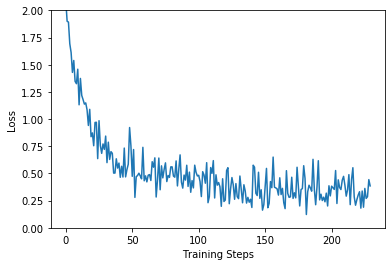

In [30]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

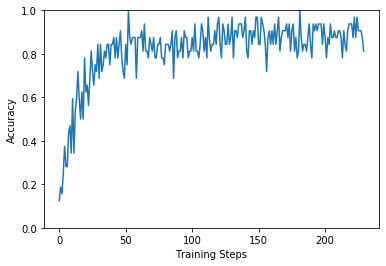

In [31]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [32]:
class_names = sorted(image_data.class_indices.items(),key = lambda pair:pair[1])
class_names = np.array([key.title() for key,value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [34]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch,axis = -1)
predicted_label_batch = class_names[predicted_id]

In [36]:
label_id = np.argmax(label_batch,axis = -1)

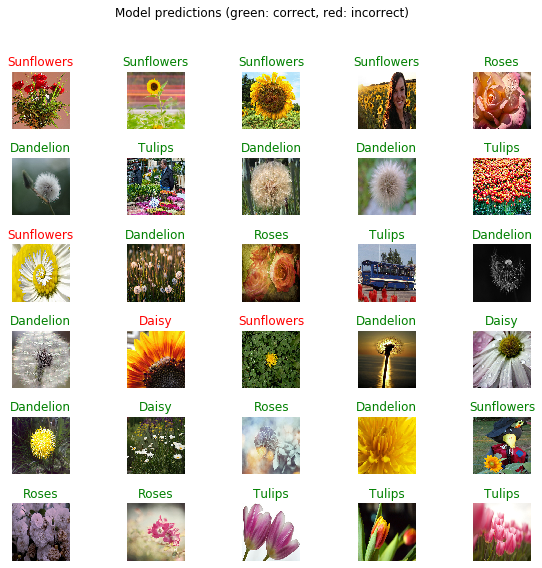

In [43]:
plt.figure(figsize =  (10,9))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(),color = color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [44]:
import time 
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format = 'tf')

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_models/1594924463\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1594924463\assets


'/tmp/saved_models/1594924463'

In [45]:
reloaded = tf.keras.models.load_model(export_path)

In [46]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [47]:
abs(reloaded_result_batch - result_batch).max()

0.0